# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [6]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=7bc51f73553c4dab738d62985c1733b25a86b68ec452cec42e01429cbdae9db0
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [7]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import nltk

from collections import Counter, defaultdict
from string import punctuation

nltk.download('stopwords')

from nltk.corpus import stopwords

sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Add any additional import statements you need here




In [9]:
# change `data_location` to the location of the folder on your machine.
data_location = "/content/drive/MyDrive/Colab Notebooks/GitHub/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [10]:
# Read in the lyrics data
artists = ['robyn','cher']

lyrics_data = pd.DataFrame(columns=['artist', 'filename', 'lyrics'])

for artist in artists:
    lyrics_files = os.listdir(data_location + lyrics_folder + artist)
    for filename in lyrics_files:
        with open(data_location + lyrics_folder + artist + "/" + filename, encoding="utf-8") as infile:
            lyrics = infile.read()
            lyrics_data = lyrics_data.append({'artist': artist, 'filename': filename, 'lyrics': lyrics}, ignore_index=True)

print(f"{len(lyrics_data)} songs successfully loaded for the artists {', '.join(artists)}.")

420 songs successfully loaded for the artists robyn, cher.


In [11]:
# Read in the twitter data
handles = ["robynkonichiwa","cher"]

twitter_data = pd.DataFrame(columns=['handle', 'description'])

for handle in handles:
    twitter_file = f"{data_location}{twitter_folder}{handle}_followers_data.txt"
    with open(twitter_file, 'r', encoding="utf-8") as infile:
        df = pd.read_csv(infile, sep='\t', skiprows=[0], header=None, usecols=[6], names=['description'])
        df['handle'] = handle
        twitter_data = twitter_data.append(df[['handle', 'description']], ignore_index=True)
            
    print(f"{len(df)} descriptions successfully loaded for the handle {handle}.")

print(f"{len(twitter_data)} descriptions successfully loaded for the handles {', '.join(handles)}.")


351839 descriptions successfully loaded for the handle robynkonichiwa.
3916321 descriptions successfully loaded for the handle cher.
4268160 descriptions successfully loaded for the handles robynkonichiwa, cher.


In [ ]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

In [22]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
# Load positive and negative words into dictionaries
pos_score = 1
neg_score = -1
pos_words = set(pd.read_csv(data_location + positive_words_file, header=None, names=['word'], encoding='latin-1')['word'])
neg_words = set(pd.read_csv(data_location + negative_words_file, header=None, names=['word'], encoding='latin-1')['word'])
word_dict = {}
for word in pos_words:
    word_dict[word] = pos_score
for word in neg_words:
    word_dict[word] = neg_score


In [20]:
# Load the tidytext sentiment
tidytext_sentiment = pd.read_csv(data_location + tidy_text_file, usecols=['word', 'sentiment'], delimiter='\t')

# Convert tidytext sentiment to a dictionary
sentiment_dict = dict(zip(tidytext_sentiment['word'], tidytext_sentiment['sentiment']))

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [28]:
# your code here
def get_sentiment_score(text):
    # Tokenize the text into individual words
    words = word_tokenize(text.lower())
    
    # Calculate the sentiment score
    sentiment_score = 0
    for word in words:
        # Look up the sentiment of the word in the dictionary
        sentiment = sentiment_dict.get(word)
        
        # If the sentiment is positive, add 1 to the score
        if sentiment == 'positive':
            sentiment_score += 1
        # If the sentiment is negative, subtract 1 from the score
        elif sentiment == 'negative':
            sentiment_score -= 1
    
    # Normalize the sentiment score by the number of words in the text
    normalized_sentiment_score = sentiment_score / len(words) if len(words) > 0 else 0
    
    return normalized_sentiment_score

# Apply the sentiment scoring function to the lyrics dataframe
lyrics_data['sentiment_score'] = lyrics_data['lyrics'].apply(get_sentiment_score)

Q: Overall, which artist has the higher average sentiment per song? 

A: <!-- Your answer here --> robyn has the higher sentiment score with a score of 0.029665

In [25]:
avg_sentiment = lyrics_data.groupby('artist')['sentiment_score'].mean()
print(avg_sentiment)

artist
cher     0.026867
robyn    0.029665
Name: sentiment_score, dtype: float64


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here --> they is have more positive words in the top three or have a higher frequency of the negative words in bottom three 

In [32]:
artist = 'robyn'
artist_lyrics = lyrics_data[lyrics_data['artist'] == artist]
artist_lyrics_sorted = artist_lyrics.sort_values('sentiment_score', ascending=False)

print(f"Top 3 songs by {artist} with highest sentiment:")
for i in range(3):
    print(artist_lyrics_sorted.iloc[i]['lyrics'])
    print("-----")

print(f"Top 3 songs by {artist} with lowest sentiment:")
for i in range(-1, -4, -1):
    print(artist_lyrics_sorted.iloc[i]['lyrics'])
    print("-----")

Top 3 songs by robyn with highest sentiment:
"Baby Forgive Me"



Here come the night
In your eyes
Baby, be brave
Be wise
It's up to you
You do what you like, mmm
Won't you give it a chance, baby?
Just one more try

Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me

(Won't you give it a chance, baby?)
Won't you give it a chance, baby?
Just one more try
One more try
Yeah, eh

You got the power
You set the price
But baby, be fair
Be nice
You say you want to be happy
Then you got to put your love on the line
Just let me make you smile again, baby
I know we can work it out
Yes, I know we can

Baby forgive me
Yeah
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me

-----
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom b

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: <!-- Your answer here -->they is have more positive words in the top three or have a higher frequency of the negative words in bottom three 


In [34]:
artist = 'cher'
artist_lyrics = lyrics_data[lyrics_data['artist'] == artist]
artist_lyrics_sorted = artist_lyrics.sort_values('sentiment_score', ascending=False)

print(f"Top 3 songs by {artist} with highest sentiment:")
for i in range(3):
    print(artist_lyrics_sorted.iloc[i]['lyrics'])
    print("-----")

print(f"Top 3 songs by {artist} with lowest sentiment:")
for i in range(-1, -4, -1):
    print(artist_lyrics_sorted.iloc[i]['lyrics'])

Top 3 songs by cher with highest sentiment:
"My Love"



When I go away
I know my heart can stay with my love
It's understood
Everywhere with my love
My love does it good, whoa
My love, oh only my love
My love does it good

And when the cupboard's bare
I'll still find something there with my love
It's understood
Everywhere with my love
My love does it so good, whoa
My love, oh only my love
My love does it good

Only my love, oh only my love
Only my love, hold the other things to me
Oh, only my love, oh only my love
Only my love does it good to me

Everywhere with my love
Don't you see my love
It does it so good
Oh, only my love, only my love
My love does it good

Don't ever ask me why
I never say "good-bye" to my love
It's understood
'Cause everywhere with my love
My love does it good, whoa
Only my love, oh only my love
My love does it good

Oh only my love
Only my love does it good to me,whoa

-----
"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.


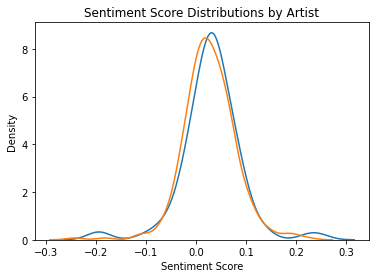

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt 
# Filter the data by artist
robyn_data = lyrics_data[lyrics_data['artist'] == 'robyn']
cher_data = lyrics_data[lyrics_data['artist'] == 'cher']

# Plot the distributions using seaborn
sns.kdeplot(data=robyn_data['sentiment_score'], label='Robyn')
sns.kdeplot(data=cher_data['sentiment_score'], label='Cher')

# Add a title and axis labels
plt.title('Sentiment Score Distributions by Artist')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

# Show the plot
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [39]:
# your code here

In [43]:
# Define the positive and negative emojis 
positive_emojis = ['😀', '😁', '😂', '😊', '😍', '😘', '🤗', '👍', '💯', '🔥']
negative_emojis = ['😔', '😞', '😢', '😠', '😡', '👎', '💔', '💩', '👿', '🤬']
positive_score = 1
negative_score = -1


In [44]:
# Define a function to score the sentiment based on the emojis 
def score_emoji_sentiment(description):
    sentiment_score = 0
    for char in description:
        if char in positive_emojis:
            sentiment_score += positive_score
        elif char in negative_emojis:
            sentiment_score += negative_score
    return sentiment_score

In [45]:
# your code here
# Apply the score_emoji_sentiment function to the Twitter dataframe
twitter_data['sentiment_score'] = twitter_data['description'].astype(str).apply(score_emoji_sentiment)

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

In [47]:
avg_sentiment = twitter_data.groupby('handle')['sentiment_score'].mean()
print(avg_sentiment)

handle
cher              0.009437
robynkonichiwa    0.004351
Name: sentiment_score, dtype: float64



Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 



In [49]:
# Define a function to count the number of times each emoji appears in the dataframe
def count_emojis(emojis, data):
    emoji_counts = {}
    for emoji in emojis:
        count = data['description'].str.count(emoji).sum()
        emoji_counts[emoji] = count
    return emoji_counts


In [50]:
#for cher
cher_data = twitter_data[twitter_data['handle'] == 'cher']

# Count the number of positive and negative emojis for Cher's followers
positive_counts = count_emojis(positive_emojis, cher_data)
negative_counts = count_emojis(negative_emojis, cher_data)

# Determine the most popular positive and negative emojis
most_popular_positive = max(positive_counts, key=positive_counts.get)
most_popular_negative = max(negative_counts, key=negative_counts.get)

# Print the most popular positive and negative emojis
print(f"The most popular positive emoji for Cher's followers is {most_popular_positive}")
print(f"The most popular negative emoji for Cher's followers is {most_popular_negative}")

The most popular positive emoji for Cher's followers is 😍
The most popular negative emoji for Cher's followers is 💔


In [51]:
#for robynkonichiwa
robyn_data = twitter_data[twitter_data['handle'] == "robynkonichiwa"]

# Count the number of positive and negative emojis for Cher's followers
positive_counts = count_emojis(positive_emojis, robyn_data)
negative_counts = count_emojis(negative_emojis, robyn_data)

# Determine the most popular positive and negative emojis
most_popular_positive = max(positive_counts, key=positive_counts.get)
most_popular_negative = max(negative_counts, key=negative_counts.get)

# Print the most popular positive and negative emojis
print(f"The most popular positive emoji for robynkonichiwa's followers is {most_popular_positive}")
print(f"The most popular negative emoji for robynkonichiwa's followers is {most_popular_negative}")

The most popular positive emoji for robynkonichiwa's followers is 🔥
The most popular negative emoji for robynkonichiwa's followers is 💔
